# Clustering 
## [Cleaning](#cleaning)
- [renaming columns](#renamingColumns)
- [converting strings to numericals](#cleaning)

## [Feature Engineering](#featureEngineering)
- [bust size conversion](#bustSize)
- [height conversion](#heightConversion)
- [creating dummy variables for body types](#bodyTypeDummy)

## [Clustering](#clustering)
- [helper methods](#helperMethods)
- [first kmeans](#kmeans1)
    - [investigating optimal k](#investigatingK1)
    - [modelling](#modelling1)
    - [cluster analysis](#clusterAnalysis1)
    - [visual](#visual1)
- [second kmeans](#kmeans1)
    - [manipulating features](#manipulatingFeatures)
    - [investigating optimal k](#investigatingK2)
    - [modelling](#modelling2)
    - [cluster analysis](#clusterAnalysis2)
    - [visual](#visual2)
- [hierarchical](#hier)
    - [cluster analysis](#clusterAnalysis3)
    - [visual](#visual3)
- [dbscan](#dbscan)
    - [cluster analysis](#clusterAnalysis4)
    - [visual](#visual4)

In [21]:
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import scale
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from pymongo import MongoClient
import pandas as pd
import numpy as np
from seaborn import plt
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as mplt
from sklearn.cluster import DBSCAN
import seaborn as sns
import patsy
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
%matplotlib inline

In [2]:
client = MongoClient('ec2-34-198-179-91.compute-1.amazonaws.com', 27017)
db = client.fletcher
dress_col = db.rtr_dresses
rev_col = db.rtr_reviews

In [3]:
cur = rev_col.find()
df =  pd.DataFrame(list(cur))
del df['_id']

In [4]:
cur_2 = dress_col.find()
dress_df =  pd.DataFrame(list(cur_2))
del dress_df['_id']

<a id="cleaning"></a>
## Cleaning
<a id="renamingColumns"></a>
### Renaming Columns

In [5]:
new_cols = []
for col in df.columns:
    new_c = col.lower().strip().replace(' ', '_')
    new_c = new_c.replace(':', '')
    new_cols.append(new_c)
df.columns = new_cols

<a id="clearning"></a>
### Converting strings to numericals

In [6]:
df.rating = df['rating'].str.extract(r'stars-([\d]+)', expand=True).astype(float)
df.loc[df.age.notnull(), 'age'] = df[df.age.notnull()].age.astype(float)

Remove ages that does't make sense

In [7]:
df.loc[df.age < 10, 'age'] = np.nan
df.loc[df.age > 100, 'age'] = np.nan

Getting additional weight or height data from the comments.

In [8]:
df.loc[(df.weight.isnull()) & (df.review.str.contains('lbs')), 'weight'] = df[(df.weight.isnull()) & (df.review.str.contains('lbs'))].review.str.extract('([\d]+)[\s]?lbs', expand=True)
df.loc[df.height.isnull(), 'height'] = df[df.height.isnull()].review.str.extract(r'(\d+\s?\'\s?\d+)', expand=True)

Looking into the comments to see whether the user is pregnant by searching for the word "pregnant"

In [9]:
df['pregnant'] = df.review.str.contains('pregnant', case=False)

In [10]:
df.loc[df.usually_wears == '24+', 'usually_wears'] = '24'

<a id="featureEngineering"></a>
## Feature Engineering
I want to take features that are specifi to the person, so that I can cluster people based on body types. From the data, I can use these values:
- age
- body_type
- bust_size 
- height 
- weight 
- usually_wears
- pregnant

In [11]:
df_body = df[['age', 'body_type', 'bust_size', 'height', 'usually_wears', 'pregnant', 'weight']]
df_body = df_body.dropna()

<a id="bustSize"></a>
## Bust size conversion

In [12]:
import pickle
under_bust_dict = pickle.load( open( "../data/under_bust.pkl", "rb" ) )
upper_bust_dict = pickle.load( open( "../data/upper_bust.pkl", "rb" ) )

In [13]:
df_body['cup'] = df_body.bust_size.str.extract('\d+(.*)', expand=True)
df_body['band_size'] = df_body.bust_size.str.extract('(\d+).*', expand=True)
df_body.loc[df_body.cup == 'D+', 'cup'] = 'DD'
df_body.band_size = df_body.band_size.astype(int)
for cup in df_body.cup.unique():
    df_body.loc[df_body.cup == cup, 'upper_bust'] = df_body[df_body.cup == cup].band_size.replace(upper_bust_dict[cup])

In [14]:
df_body['under_bust'] = df_body.band_size.replace(under_bust_dict)
df_body.weight = df_body.weight.str.extract('(\d+)\s?lbs', expand=True)
df_body.weight = df_body.weight.astype(int)
del df_body['cup']
del df_body['band_size']

<a id="heightConversion"></a>
## Height conversion

In [15]:
df_body['feet'] = df_body.height.str.extract(r'(\d)\'', expand=True).astype(int)
df_body['inches'] = df_body.height.str.extract(r'\d\'\s?(\d+)', expand=True).astype(int)
df_body['height_in'] = df_body.feet * 12 + df_body.inches
del df_body['feet']
del df_body['inches']

In [16]:
df_body.age = df_body.age.astype(int)
df_body.usually_wears = df_body.usually_wears.astype(int)

In [17]:
# sanity checks
df_body[df_body.weight < 80] = np.nan
df_body = df_body.dropna()

<a id="bodyTypeDummy"></a>
## Body types dummy variables

In [18]:
df_X = df_body[['age', 'usually_wears', 'pregnant', 'weight', 'upper_bust', 'under_bust', 'height_in']]

In [20]:
# make dummys for body types
df_body_type = patsy.dmatrix('body_type',data=df_body,return_type='dataframe')
df_X= df_X.join(df_body_type)
df_X = pd.DataFrame(normalize(df_X, axis=0, norm='max'), columns = df_X.columns)

In [22]:
del df_X['Intercept']

<a id="clustering"></a>
# Clustering
<a id="helperMethods"></a>
## Helper methods

In [90]:
def print_medians(df, columns, label_col, categories, metric='mean'):
    for label in df[label_col].unique():
        cur_type = df[df[label_col] == label]
        print('--------LABEL #{}---------'.format(label))
        for col in columns:
            if metric == 'mean' or metric == 'both':
                print('{} MEAN: {}'.format(col, cur_type[col].mean()))
            if metric == 'median' or metric == 'both':
                print('{} MEDIAN: {}'.format(col, cur_type[col].median()))
        print('****Categories****')
        for cat in categories:
            print(cur_type.groupby(cat).size())

In [91]:
def my_print_medians(df, label):
    print_medians(df, columns=['upper_bust', 'under_bust', 'height_in', 'weight', 'age'],
              categories=['body_type', 'pregnant'], metric='both', label_col=label)

In [65]:
def display_category_distribution(df, cat, label, ax, val=1):
    df_cat = df[df[cat]==val].groupby(label).size()
    xrange = np.arange(df_cat.keys().shape[0])
    ax.bar(xrange, df_cat.values, align='center')
    ax.set_xticks(xrange)
    ax.set_xticklabels(df_cat.keys())
    ax.set_title('{} == {} distribution'.format(cat, val), y=1.2)
    ax.set_xlabel('cluster #')
    ax.set_ylabel('count')

In [42]:
def display_all_category_distribution(df, label_col):
    fig, axes = plt.subplots(3,3,figsize=(10, 6))
    fig.subplots_adjust(wspace=1)
    fig.subplots_adjust(hspace=1)
    for i, bt in enumerate(df.body_type.unique()):
        display_category_distribution(df, 'body_type', label_col, axes.flatten()[i], val=bt)
    display_category_distribution(df, 'pregnant', label_col, axes.flatten()[7])
        

In [80]:
def pairplot_clusters(df, columns, label_col):
    sns.pairplot(df_body, vars=columns, hue=label_col)

In [94]:
def my_pairplot_clusters(df, label_col):
    sns.pairplot(df, vars=["upper_bust", "under_bust", "height_in", "usually_wears", "weight"], hue=label_col)

In [23]:
import time
def plot_kmeans(df, k_clusters = range(4,10)):
    sses = []
#     sil_coefs = []
    for k in k_clusters:
        st = time.time()
        print('Starting kmeans on k={}'.format(k))
        km = KMeans(n_clusters=k, random_state=1)
        print('Elapsed time: {}'.format(time.time() - st))
        km.fit(df)
        labels = km.labels_
#         sil_coefs.append(silhouette_score(df, labels, metric='euclidean'))
        sses.append(km.inertia_)
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True)
#     ax1.plot(k_clusters, sil_coefs)
    fig, ax = plt.subplots()
#     ax.set_xlabel('number of clusters')
#     ax.set_ylabel('silhouette coefficient')

    # plot here on ax2
    ax.plot(k_clusters, sses)
    ax.set_xlabel('number of clusters')
    ax.set_ylabel('SSE');


<a id="kmeans1"></a>
## KMeans - 1

<a id="investigatingK1"></a>
### investigating optimal k

Starting kmeans on k=4
Elapsed time: 9.512901306152344e-05
Starting kmeans on k=5
Elapsed time: 9.083747863769531e-05
Starting kmeans on k=6
Elapsed time: 5.1975250244140625e-05
Starting kmeans on k=7
Elapsed time: 8.893013000488281e-05
Starting kmeans on k=8
Elapsed time: 3.409385681152344e-05
Starting kmeans on k=9
Elapsed time: 8.797645568847656e-05


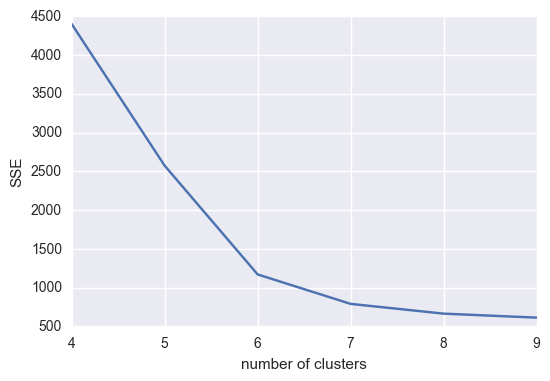

In [24]:
plot_kmeans(df_X, k_clusters=range(4,10))

The best number for k is 6.

<a id="modelling1"></a>
### modelling

In [34]:
km = KMeans(n_clusters=6, random_state=1)
km.fit(df_X)
labels = km.labels_

In [35]:
df_body['kmean_label'] = labels

<a id="clusterAnalysis1"></a>
### cluster analysis

In [92]:
my_print_medians(df_body, 'kmean_label')

--------LABEL #3---------
upper_bust MEAN: 91.98973838520523
upper_bust MEDIAN: 92.5
under_bust MEAN: 76.32611637347767
under_bust MEDIAN: 75.0
height_in MEAN: 65.91294542174109
height_in MEDIAN: 66.0
weight MEAN: 136.47812359043752
weight MEDIAN: 135.0
age MEAN: 32.1553901668922
age MEDIAN: 31.0
****Categories****
body_type
Athletic    4434
dtype: int64
pregnant
0.0    4407
1.0      27
dtype: int64
--------LABEL #0---------
upper_bust MEAN: 95.1095529491756
upper_bust MEDIAN: 95.5
under_bust MEAN: 77.36698963114057
under_bust MEDIAN: 75.0
height_in MEAN: 65.44688084310725
height_in MEDIAN: 65.0
weight MEAN: 146.05371409144993
weight MEDIAN: 140.0
age MEAN: 33.085670576236616
age MEDIAN: 32.0
****Categories****
body_type
Hourglass    5883
dtype: int64
pregnant
0.0    5835
1.0      48
dtype: int64
--------LABEL #5---------
upper_bust MEAN: 89.47116052814455
upper_bust MEDIAN: 90.0
under_bust MEAN: 75.58721334259903
under_bust MEDIAN: 75.0
height_in MEAN: 66.78596247394023
height_in MEDI

<a id="visual1"></a>
### Clustering visualization

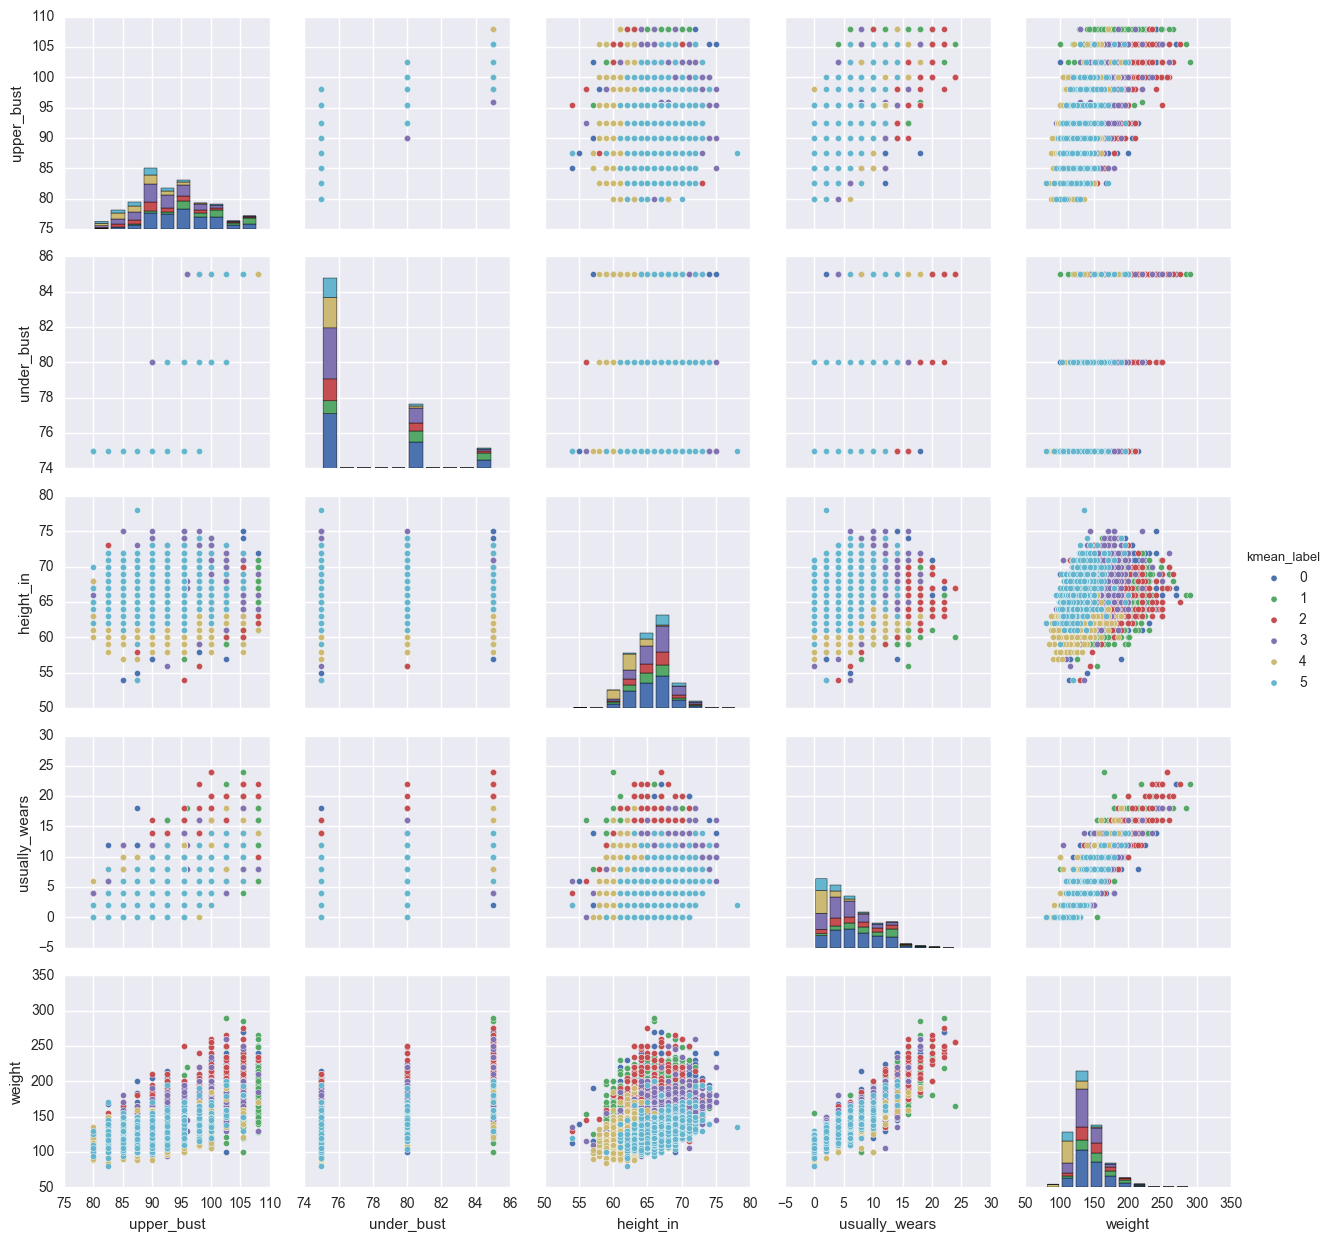

In [95]:
my_pairplot_clusters(df_body, 'kmean_label')

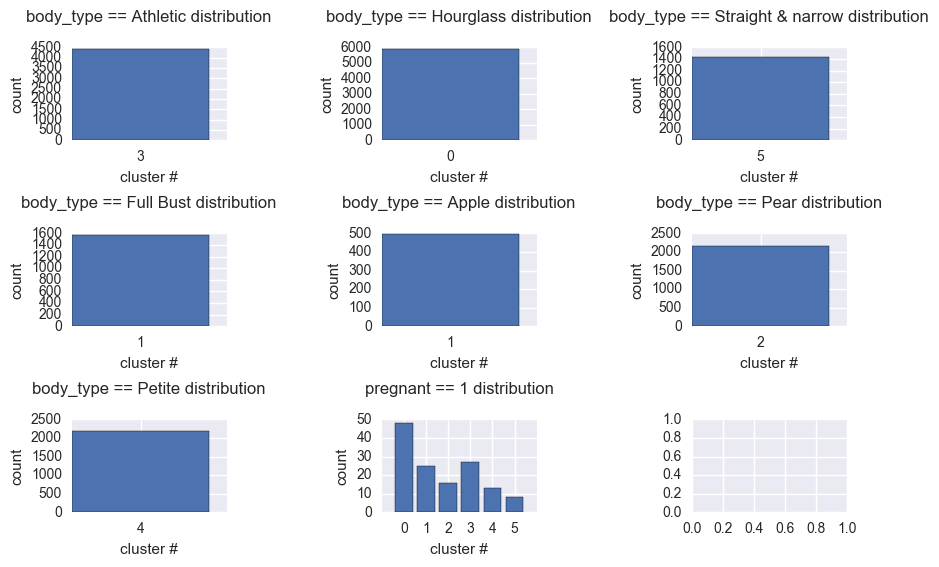

In [66]:
display_all_category_distribution(df_body, 'kmean_label')


- They're simply clustering on body types.
- I have to tweak the coefficients.

<a id="kmeans2"></a>
## KMeans - 2

<a id="manipulatingFeatures"></a>
### manipulating features 

In [50]:
df_X_2 = df_X.copy()

The problem is, kmeans will split by the different body types because the distance of a person with, for example an athletic body, to someone in pear shaped will be distance of 1, which is further away than the other sort of features. I have to multiply these categorical columns by a fraction to make them closer together. I have chosen **0.2**


In [51]:
for col in df_X_2.columns.values[7:]:
    df_X_2[col] = df_X_2[col] * 0.2

I think that weight and height are important features; I will multiply these features by 1.5, so that there's more division between these categories. I also don't want to isolate the pregnant ones by themselves - so that I've multiplied them also by 0.2. For under bust, there's only 3 different measures, thus I will multiply them by 0.5. Age is also not a very strong factor in terms of boyd types - thus I will multiply it by 0.5

In [52]:
df_X_2['weight'] = df_X_2['weight'] * 1.5
df_X_2['height_in'] = df_X_2['height_in'] * 1.5
df_X_2['pregnant'] = df_X_2['pregnant'] * 0.2
df_X_2['under_bust'] = df_X_2['under_bust'] * 0.5
df_X_2['age'] = df_X_2['age'] * 0.5

<a id="investigatingK2"></a>
### investigating optimum k

Starting kmeans on k=4
Elapsed time: 9.107589721679688e-05
Starting kmeans on k=5
Elapsed time: 0.0001220703125
Starting kmeans on k=6
Elapsed time: 9.012222290039062e-05
Starting kmeans on k=7
Elapsed time: 8.893013000488281e-05
Starting kmeans on k=8
Elapsed time: 8.916854858398438e-05
Starting kmeans on k=9
Elapsed time: 9.298324584960938e-05
Starting kmeans on k=10
Elapsed time: 0.0001010894775390625
Starting kmeans on k=11
Elapsed time: 9.393692016601562e-05
Starting kmeans on k=12
Elapsed time: 7.605552673339844e-05
Starting kmeans on k=13
Elapsed time: 0.00011396408081054688
Starting kmeans on k=14
Elapsed time: 7.200241088867188e-05
Starting kmeans on k=15
Elapsed time: 7.104873657226562e-05
Starting kmeans on k=16
Elapsed time: 0.0001728534698486328
Starting kmeans on k=17
Elapsed time: 7.176399230957031e-05
Starting kmeans on k=18
Elapsed time: 6.794929504394531e-05
Starting kmeans on k=19
Elapsed time: 0.0003910064697265625


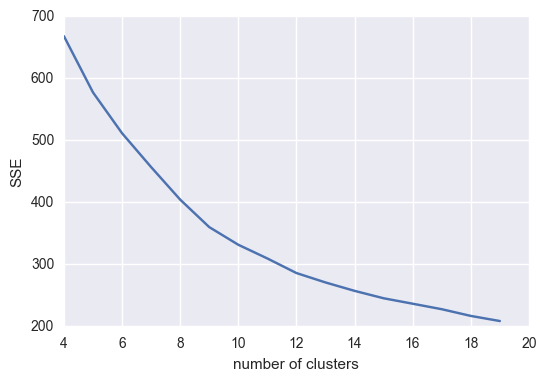

In [55]:
plot_kmeans(df_X_2, k_clusters=range(4, 20))

<a id="modelling2"></a>
### modelling

In [56]:
km = KMeans(n_clusters=12, random_state=1)
km.fit(df_X_2)
labels = km.labels_

In [57]:
df_body['kmean_label_2'] = labels

<a id="clusterAnalysis2"></a>
### cluster analysis

In [93]:
my_print_medians(df_body, 'kmean_label_2')

--------LABEL #4---------
upper_bust MEAN: 89.95201723462593
upper_bust MEDIAN: 90.0
under_bust MEAN: 75.31335683509596
under_bust MEDIAN: 75.0
height_in MEAN: 65.22522522522523
height_in MEDIAN: 65.0
weight MEAN: 126.9596553074814
weight MEDIAN: 127.0
age MEAN: 31.307089698394048
age MEDIAN: 30.0
****Categories****
body_type
Apple          2
Athletic    2551
dtype: int64
pregnant
0.0    2541
1.0      12
dtype: int64
--------LABEL #0---------
upper_bust MEAN: 94.53641304347826
upper_bust MEDIAN: 95.5
under_bust MEAN: 77.52989130434783
under_bust MEDIAN: 75.0
height_in MEAN: 66.825
height_in MEDIAN: 67.0
weight MEAN: 148.07934782608694
weight MEDIAN: 145.0
age MEAN: 33.20923913043478
age MEDIAN: 32.0
****Categories****
body_type
Apple          9
Athletic    1831
dtype: int64
pregnant
0.0    1827
1.0      13
dtype: int64
--------LABEL #2---------
upper_bust MEAN: 94.89684304135172
upper_bust MEDIAN: 95.5
under_bust MEAN: 76.76745220097821
under_bust MEDIAN: 75.0
height_in MEAN: 65.536682

<a id="visual2"></a>
### Clustering visualization

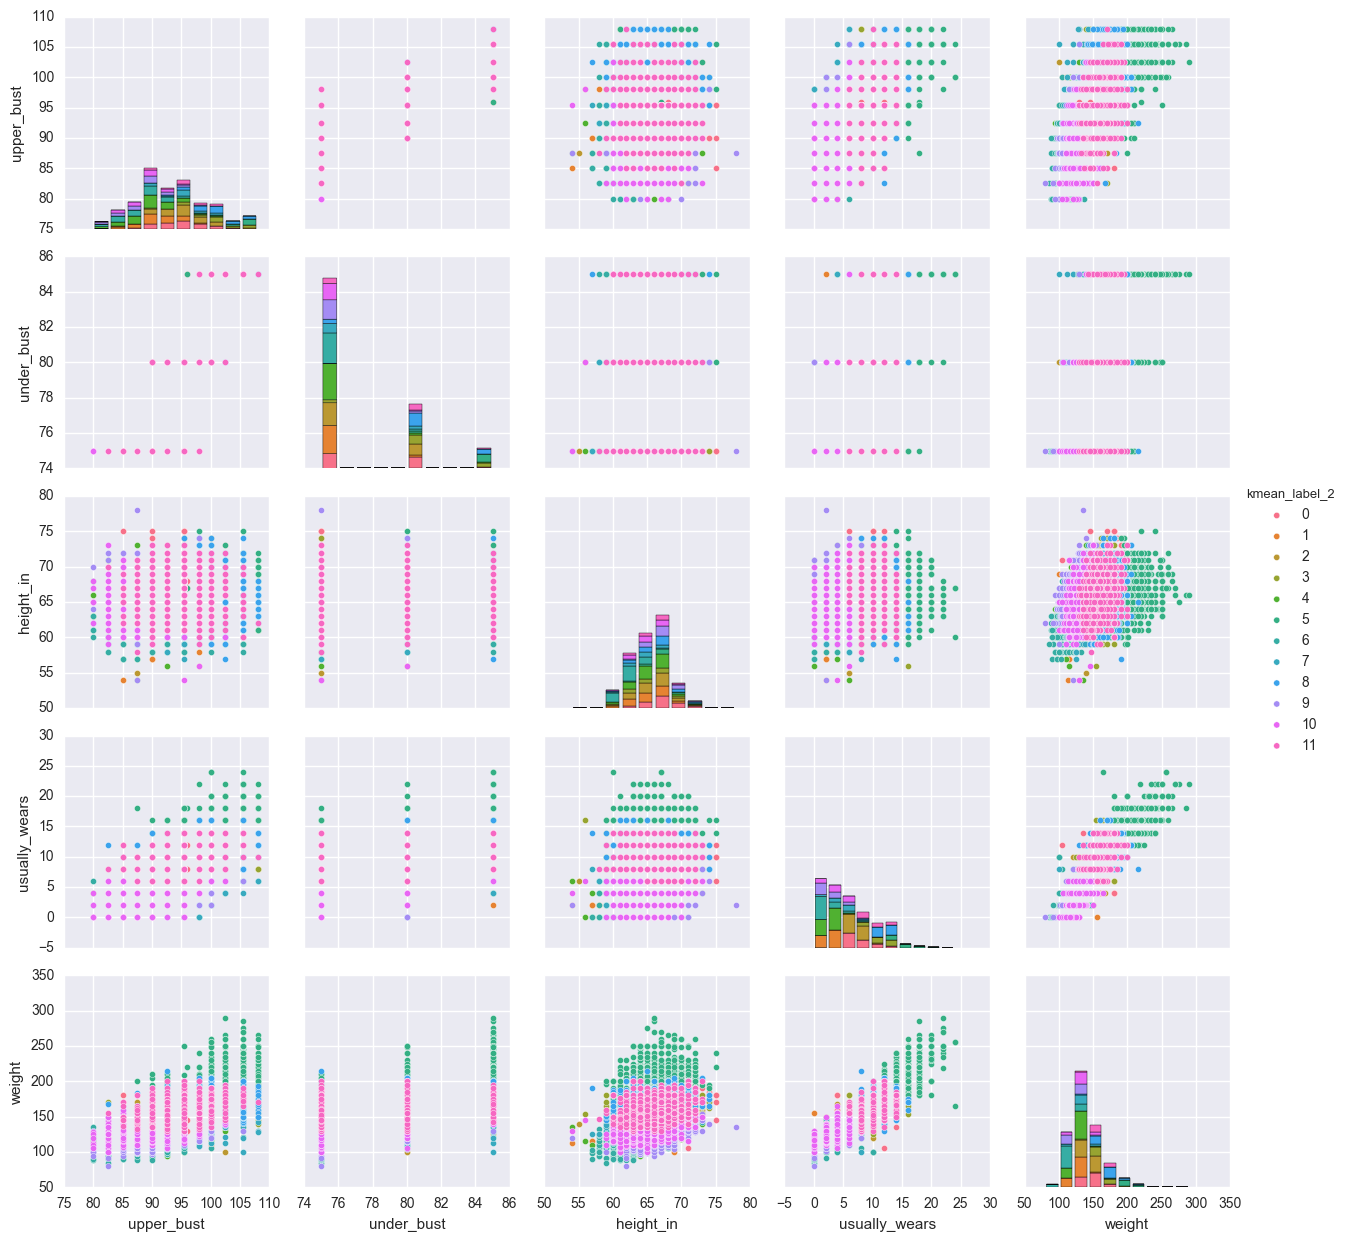

In [96]:
my_pairplot_clusters(df_body, 'kmean_label_2')

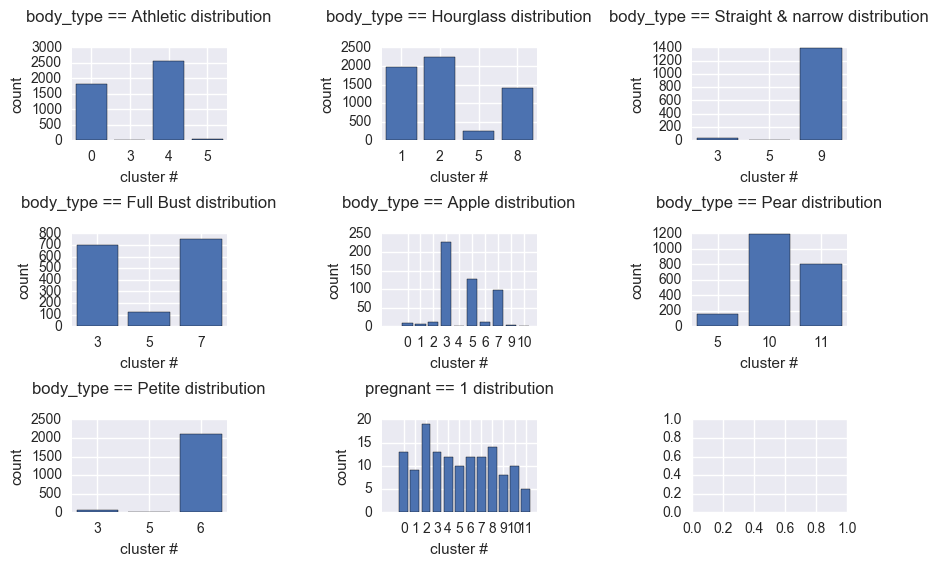

In [68]:
display_all_category_distribution(df_body, 'kmean_label_2')

<a id="hier"></a>
## Hierarchical Clustering

In [69]:
ac = AgglomerativeClustering(n_clusters=10)
ac.fit(df_X_2)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=10,
            pooling_func=<function mean at 0x1097b31e0>)

In [70]:
df_body['ac_label'] = ac.labels_

<a id="clusterAnalysis3"></a>
### cluster analysis

In [97]:
my_print_medians(df_body, 'ac_label')

--------LABEL #8---------
upper_bust MEAN: 89.92585630743525
upper_bust MEDIAN: 90.0
under_bust MEAN: 75.29657477025899
under_bust MEDIAN: 75.0
height_in MEAN: 65.3078529657477
height_in MEDIAN: 65.0
weight MEAN: 127.1624895572264
weight MEDIAN: 128.0
age MEAN: 30.627401837928154
age MEDIAN: 30.0
****Categories****
body_type
Athletic    2394
dtype: int64
pregnant
0.0    2394
dtype: int64
--------LABEL #7---------
upper_bust MEAN: 94.2877024291498
upper_bust MEDIAN: 95.5
under_bust MEAN: 77.41902834008097
under_bust MEDIAN: 75.0
height_in MEAN: 66.60121457489879
height_in MEDIAN: 67.0
weight MEAN: 146.49696356275302
weight MEDIAN: 145.0
age MEAN: 33.909919028340084
age MEDIAN: 32.0
****Categories****
body_type
Athletic    1976
dtype: int64
pregnant
0.0    1976
dtype: int64
--------LABEL #2---------
upper_bust MEAN: 92.43508287292818
upper_bust MEDIAN: 92.5
under_bust MEAN: 75.68446899938613
under_bust MEDIAN: 75.0
height_in MEAN: 65.05555555555556
height_in MEDIAN: 65.0
weight MEAN: 131

<a id="visual3"></a>
### Clustering visualization

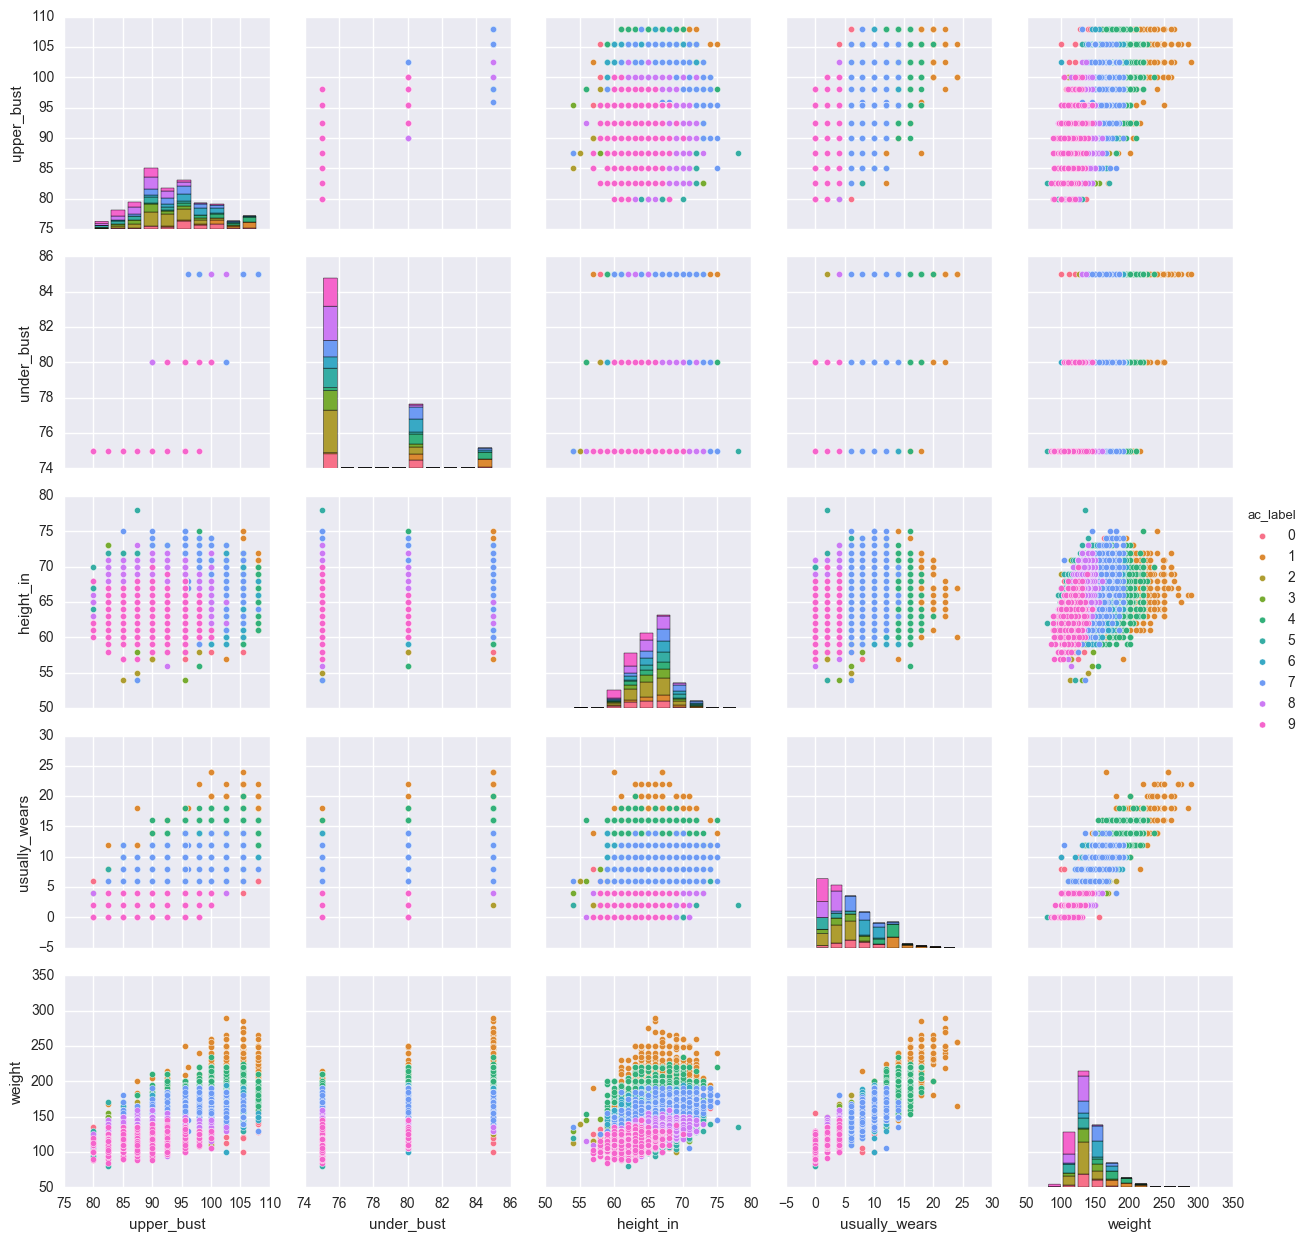

In [98]:
my_pairplot_clusters(df_body, 'ac_label')

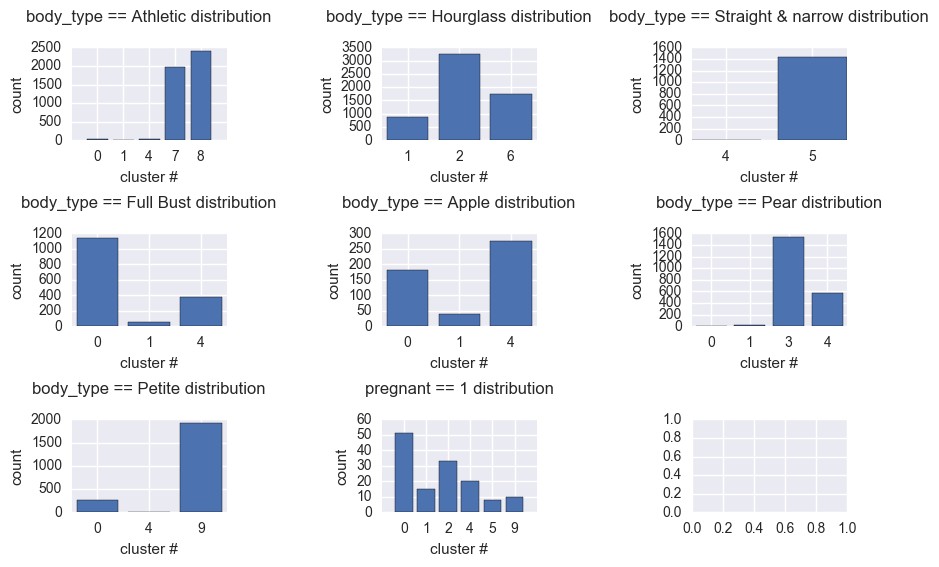

In [73]:
display_all_category_distribution(df_body, 'ac_label')

<a id="dbscan"></a>
## DBSCAN

In [74]:
db = DBSCAN(eps=0.1, min_samples=10).fit(df_X_2)

In [75]:
df_body['dbscan_label'] = db.labels_

<a id="clusterAnalysis4"></a>
### cluster analysis

In [99]:
my_print_medians(df_body, 'dbscan_label')

--------LABEL #0---------
upper_bust MEAN: 91.9639034388522
upper_bust MEDIAN: 92.5
under_bust MEAN: 76.30608061944888
under_bust MEDIAN: 75.0
height_in MEAN: 65.90776588476429
height_in MEDIAN: 66.0
weight MEAN: 136.26212707811433
weight MEDIAN: 135.0
age MEAN: 32.15395126394899
age MEDIAN: 31.0
****Categories****
body_type
Athletic    4391
dtype: int64
pregnant
0.0    4391
dtype: int64
--------LABEL #1---------
upper_bust MEAN: 95.08271774609173
upper_bust MEDIAN: 95.5
under_bust MEAN: 77.35011166466244
under_bust MEDIAN: 75.0
height_in MEAN: 65.43566397526199
height_in MEDIAN: 65.0
weight MEAN: 145.814808452156
weight MEDIAN: 140.0
age MEAN: 33.07868063906545
age MEDIAN: 32.0
****Categories****
body_type
Hourglass    5821
dtype: int64
pregnant
0.0    5821
dtype: int64
--------LABEL #2---------
upper_bust MEAN: 89.38499646142958
upper_bust MEDIAN: 90.0
under_bust MEAN: 75.53432413305025
under_bust MEDIAN: 75.0
height_in MEAN: 66.77140835102618
height_in MEDIAN: 67.0
weight MEAN: 125.

<a id="visual4"></a>
### Clustering visualization

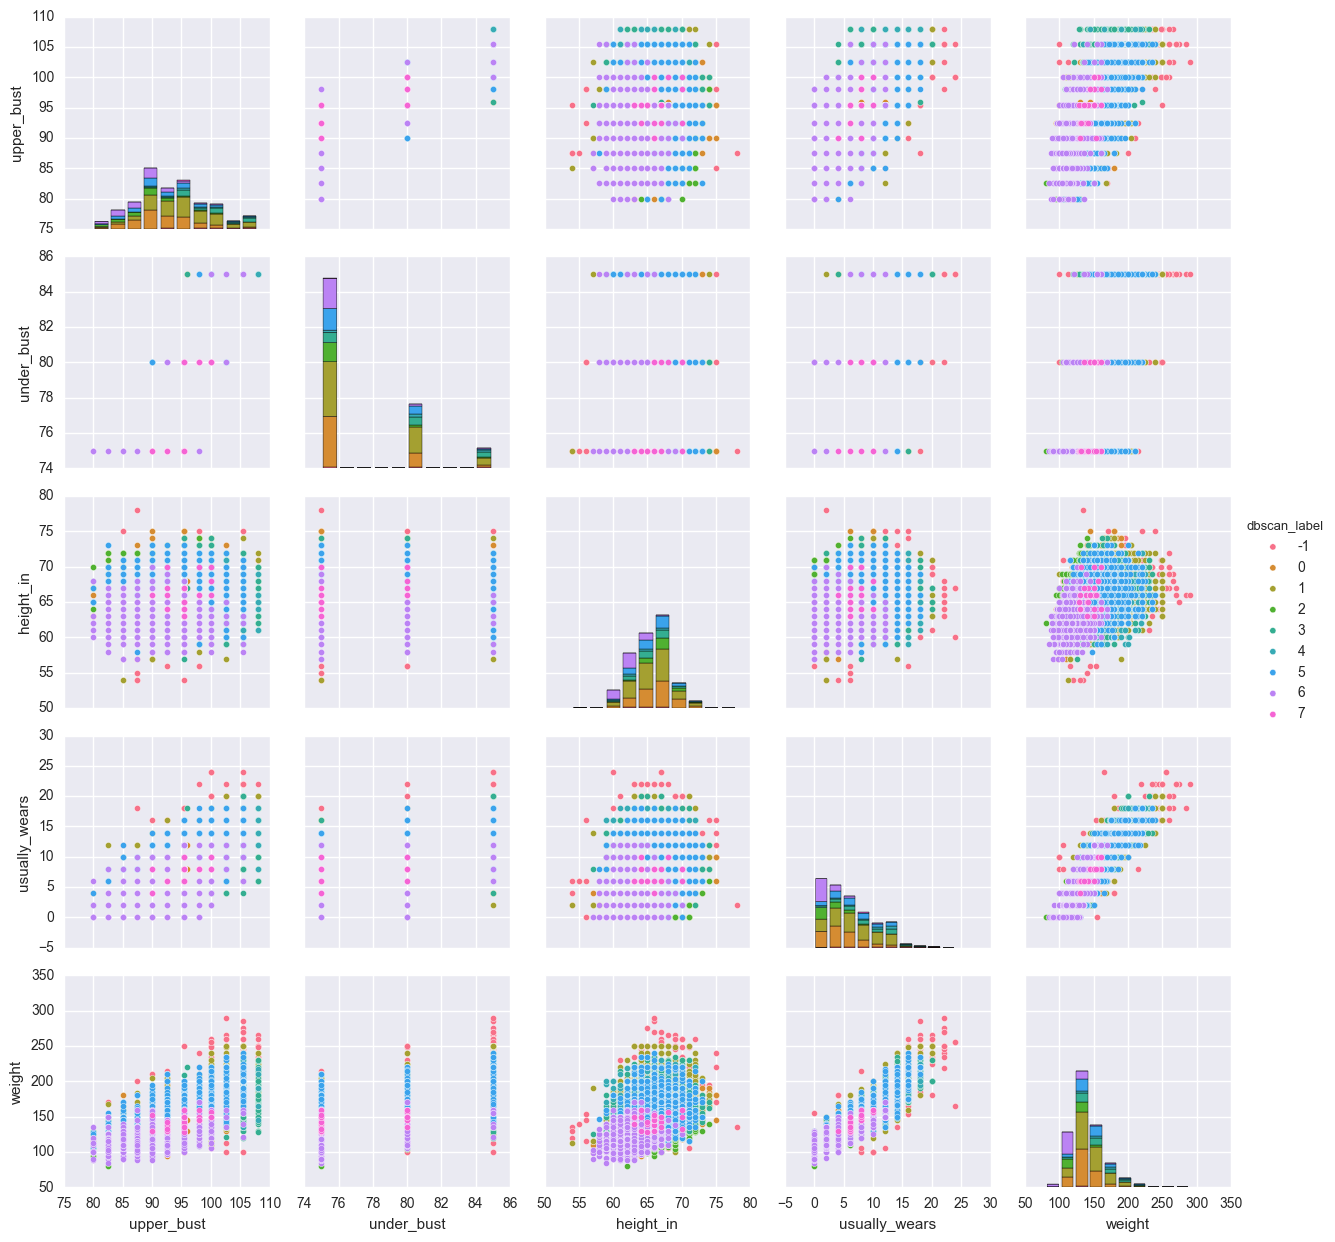

In [100]:
my_pairplot_clusters(df_body, 'dbscan_label')

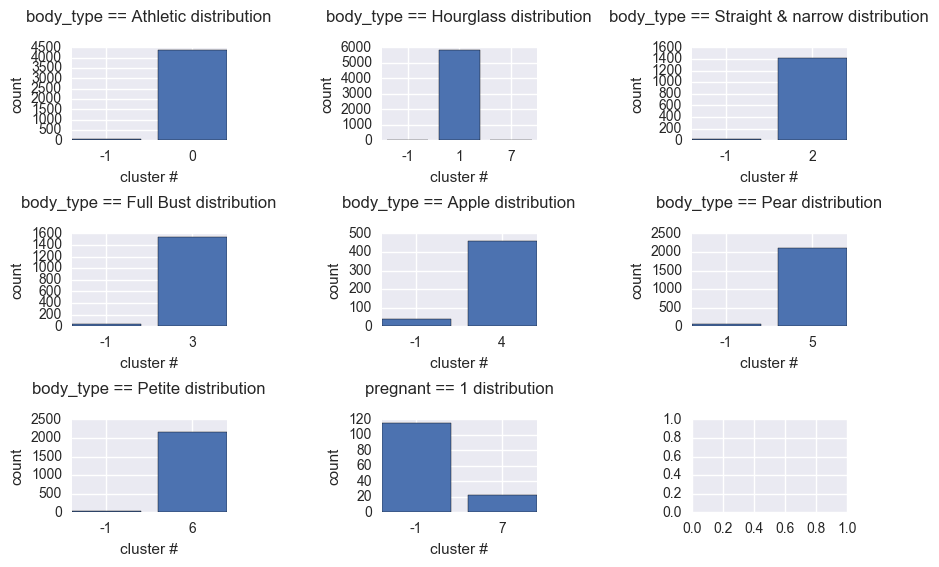

In [79]:
display_all_category_distribution(df_body, 'dbscan_label')

DBSCAN isolated the pregnant ones. It seems to cluster on body types as well. This is similar to the first kmeans model. Overall, the second kmeans model and ward hierarchical clustering does well.